Put EQ6 & EQ7 into the for loop. It worked!
Reformulate EQ3 (cancellation) to be correct. It worked!
Fix the end period-values to 0.

### Setup

EU ETS is simulated for the years 2020-2064. t=0 is 2020, and so t=44 is 2065. Supply and demand is zero from year 2065, by the calibration.

In [3]:
import pandas as pd
import numpy as np

# Generate a list for time periods t that ranges from 0 to 45. Generate a corresponding list for the years of the scheme.
t = list(range(0, 45))
year = list(map(str, range(2020, 2065)))

# Generate dictionnary
dictionnary = {'t': t, 'year':year}

# Generate Dataframe from dictionnary
df = pd.DataFrame(dictionnary)


### Variables

In [4]:
# Add alpha to the Dataframe
alpha = []

for value in df["t"]:
    if value <= 3:
        alpha.append(0.24)
    if value > 3:
        alpha.append(0.12)
        
df["alpha"] = alpha

# Add supply to the Dataframe
s_t = []

for value in df["t"]:
    s_t.append(1859 - (1859*0.022)*value)
    
df["s(t)"] = s_t  


### Scalars, Variables and Main Equations

#### Scalars 
r - Interest rate

beta - Threshold for cancellation of allowances (as a fixed share of supply)

p0 - Average price in 2020 (t=0)

d0 - Demand in 2020 (t=0)

apar - Parameter alpha in demand function

bpar - Parameter beta in demand function

#### Variables

p(t) - Price over time

d(t) - Demand 

M(t) - Size of the MSR

B(t) - Banking of allowances

c(t) - Cancellation of allowances

m_in(t) - Inflow of allowances into the MSR

m_out(t) - Outflow out of the MSR

Total_D - Cumulative Demand over all periods

Total_C - Cumulative cancellation of allowances over all periods

#### Main Equations

EQ1: Price over time

EQ2: Demand for allowances

EQ3: Inflow of allowances into the MSR

EQ4: Outflow of allowances from MSR

EQ5: Size of MSR

EQ6: Cancellation of allowances

EQ7: Market balance

In [45]:
# Parameter for beta
beta = 0.57 

# Parameters for demand 
d0 = 1380.2
p0 = 24.76
b_par = 8.492
a_par = d0 + b_par*p0

# Add empty variables to the dataframe
df["p(t)"] = np.nan
df["d(t)"] = np.nan
df["M(t)"] = np.nan
df["B(t)"] = np.nan
df["c(t)"] = np.nan
df["m_in(t)"] = np.nan
df["m_out(t)"] = np.nan

# Set initial values for variables
df.loc[0, 'p(t)'] = 24.76
df.loc[0, 'd(t)'] = 1380.2
df.loc[0, 'M(t)'] = 1924
df.loc[0, 'B(t)'] = 1579
df.loc[0:2, 'c(t)'] = 0
df.loc[0, 'm_in(t)'] = df.loc[0, 'm_out(t)'] = 0

# Main Equations
for i in range(1, len(df)):
    df.loc[i, 'p(t)'] = df.loc[i-1, 'p(t)'] * (1 + 0.05)                                                                           # EQ1
    
    df.loc[i, 'd(t)'] = a_par - (b_par * df.loc[i, 'p(t)'])                                                                        # EQ2
    
    df.loc[i, 'm_in(t)'] = max(0, df.loc[i, 'alpha'] * df.loc[i-1, 'B(t)'] * (df.loc[i-1, 'B(t)'] - 833))\
    * (df.loc[i-1, 'B(t)'] - 833) / ((df.loc[i-1, 'B(t)'] - 833) * (df.loc[i-1, 'B(t)'] - 833) + 0.01)                             # EQ3
    
    df.loc[i, 'm_out(t)'] = min(df.loc[i-1, 'M(t)'], (max(0, 100*(400 - df.loc[i-1, 'B(t)'])) * (400 - df.loc[i-1, 'B(t)'])\
                                / ((400 - df.loc[i-1, 'B(t)']) * (400 - df.loc[i-1, 'B(t)']) + 0.01)))                             # EQ4
    
    df.loc[i, 'M(t)'] = df.loc[i-1, 'M(t)'] + df.loc[i, 'm_in(t)'] - df.loc[i, 'm_out(t)'] - df.loc[i-1, 'c(t)']                   # EQ5
    
    if df.loc[i, 't'] > 2:                                                                                                         # EQ6
        df.loc[i, 'c(t)'] = max(0, df.loc[i, 'M(t)'] - 0.57*df.loc[i, 's(t)'])
    else:
        df.loc[i, 'c(t)'] = 0

    df.loc[i, 'B(t)'] = df.loc[i, 's(t)'] - df.loc[i, 'm_in(t)'] + df.loc[i, 'm_out(t)'] - df.loc[i, 'd(t)'] + df.loc[i-1, 'B(t)'] # EQ7

df

,t,year,alpha,s(t),p(t),d(t),M(t),B(t),c(t),m_in(t),m_out(t),balance,dbalance
0,0,2020,0.24,1859.000,24.760000,1380.200000,1924.000000,1579.000000,0.000000,0.000000,0.000000,NaN,NaN
1,1,2021,0.24,1818.102,25.998000,1369.686904,2302.959993,1648.455103,0.000000,378.959993,-0.000000,1439.142007,1439.142007
2,2,2022,0.24,1777.204,27.297900,1358.648153,2698.589212,1671.381731,0.000000,395.629219,-0.000000,1381.574781,1381.574781
3,3,2023,0.24,1736.306,28.662795,1347.057465,3099.720822,1659.498656,2110.026402,401.131610,-0.000000,1335.174390,1335.174390
4,4,2024,0.12,1695.408,30.095935,1334.887242,1188.834256,1820.879578,222.451696,199.139836,-0.000000,1496.268164,1496.268164
5,5,2025,0.12,1654.510,31.600731,1322.108508,1184.888107,1934.775523,241.817407,218.505547,-0.000000,1436.004453,1436.004453
6,6,2026,0.12,1613.612,33.180768,1308.690838,1175.243761,2007.523625,255.484921,232.173061,-0.000000,1381.438939,1381.438939
7,7,2027,0.12,1572.714,34.839806,1294.602283,1160.661673,2044.732508,264.214693,240.902833,-0.000000,1331.811167,1331.811167
8,8,2028,0.12,1531.816,36.581797,1279.809302,1141.814879,2051.371307,268.679759,245.367899,-0.000000,1286.448101,1286.448101
9,9,2029,0.12,1490.918,38.410887,1264.276671,1119.299675,2031.848081,269.476415,246.164555,-0.000000,1244.753445,1244.753445


### Cumulative demand and cancellation of allowances

In [13]:
# Cumulative emissions (demand) in the cap-and-trade scheme)

Total_D = df['d(t)'].sum()
print(Total_D)

37991.92500250475


In [15]:
# Cumulative cancellation of allowances in the scheme

Total_C = df['c(t)'].sum()
print(Total_C)

6955.725906364578


### Figure 1: Market Balance

In [38]:
# Add column for 'market balance' in the dataframe
# Balance will be plotted with demande, which will be a similar figure as Figure 2 in Gerlagh et al. (2021).
df["balance"] = np.nan

for i in range(1, len(df)):
        df.loc[i, 'balance'] = df.loc[i, 's(t)'] - df.loc[i, 'm_in(t)'] + df.loc[i, 'm_out(t)']  
            

Text(0, 0.5, 'Demand and supply [MtCO2/yr]')

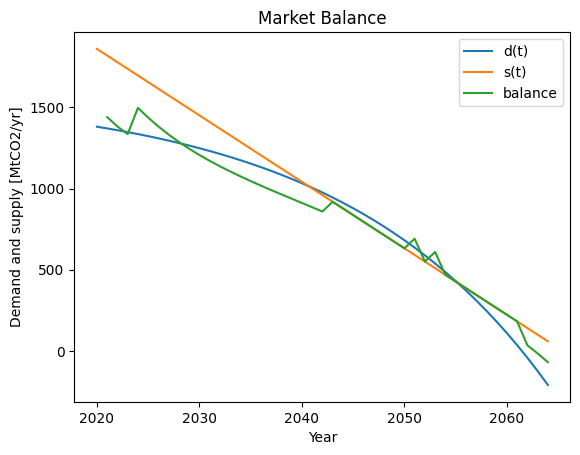

In [41]:
ax = plt.gca()

# Use plot() method on the dataframe
df.plot( x = 'year' , y = 'd(t)', ax = ax )
df.plot( x = 'year' , y = 's(t)', ax = ax )
df.plot( x = 'year' , y = 'balance' , ax = ax )
plt.title('Market Balance')
plt.xlabel('Year')
plt.ylabel('Demand and supply [MtCO2/yr]')

In [ ]:
# THIS IS WRONG!!!
# Get the EQUILIBRIUM price (end price for which b=0 in the last period)


# Solver for python to solve model quickly.
# Do figure of this.

# (Set the end year values too - related to first point)
# price side 